[*Home*](https://shivchitinous.github.io/recombinator/) | [*GitHub*](https://github.com/shivChitinous/recombinator)

# A Simple Model of Recombination

In [1]:
## HIDDEN
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('white')
import itertools

This model attempts to simulate crossing over between two genes on a chromosome to see how the recombination frequency depends on the number of loci between them as well as recombination hotspots.

Let the number of loci between the two genes be $N$ and the probability vector $p = [p_1, p_2...p_N]$ where $p_i$ is the probability that locus $i$ eperiences a crossover event.

## Equal probability of crossing over at all loci

In this section we assume that the vector $p$ is a constant vector i.e. the probability of crossing over at any given locus is a constant $\rho$.

In [2]:
N = 10
p = 0.1*np.ones(N) #1 in every 10 meioses is a crossover event at any given locus

### Crossovers

Let's define a 2D array `crossings` that represents crossover events on _one_ of the homologous chromosomes in the region between genes $\text{A}$ and $\text{B}$.

In [3]:
crossings = np.zeros([2,N])

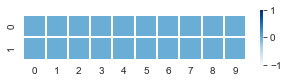

In [4]:
## HIDDEN
plt.subplots(figsize = (5,1))
sns.heatmap(crossings,linewidth = 1,cmap='Blues',vmin=-1,vmax=1,square=True);

Each position on the array represents a locus on one of the chromosomes - `row 0` represents the outer chromatid and `row 1` represents the inner chromatid. During meiosis, any of these loci can undergo crossing over. If a locus undergoes crossing over, the element representing that locus takes a value of `1`. If it doesn't undergo crossing over, the element representing that locus remains `0`.

_Note:_ Here, **we assume** that a **single chromatid can form chiasmata with only one of its non-sister chromatids**. We relax this assumption in the next section.

### Chromosomes

We can convert this representation to visualize the genes $\text{A}$ and $\text{B}$ on homologous chromosomes:

In [5]:
## HIDDEN
def chromosomes(crossings,plot=False):
    X0 = np.ones([2,2]); X1 = np.zeros([2,2])
    X0[:,1] = (np.sum(crossings>0,1)+X0[:,1])%2; X0[:,0] = (np.sum(crossings<0,1)+X0[:,0])%2
    X1[:,1] = (np.sum(crossings>0,1)+X1[:,1])%2; X1[:,0] = (np.flip(np.sum(crossings<0,1))+X1[:,0])%2
    if plot is True:
        fig,ax = plt.subplots(2,1,figsize=(1.8,4))
        sns.heatmap(X0,linewidth = 1,cmap='Set3',vmin=0,vmax=1,cbar=False,ax= ax[0],square=True,yticklabels=False)
        sns.heatmap(X1,linewidth = 1,cmap='Set3',vmin=0,vmax=1,cbar=False,ax= ax[1],square=True,yticklabels=False);
    return X0,X1

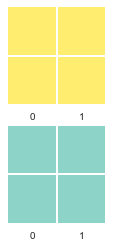

In [6]:
chromosomes(crossings,plot=True);

This represents the two parental chromosomes:
 $AABB$ and $aabb$.
Yellow represents dominant and green represents recessive, while `row 0` represents gene $\text{A}$ and `row 1` represents gene $\text{B}$.

_Note:_ Since the `crossings` array had all elements set to `0` we get the parental chromosomes in this case.

### Meiosis

Let's simulate a single meiosis event and look at the chromatids we end up with - 

In [7]:
## HIDDEN
def meiosis(N,p,state=None,sig=None,alpha=[1,0]):
    crossings = np.zeros([2,N]) #set crossovers to be 0
    
    #generating 2N random numbers
    rn = np.random.RandomState(state)
    rnd_vec = rn.rand(2*N)
    
    #selecting one of the sister chromatids
    si = np.random.RandomState(sig)
    sign = si.rand(np.sum(rnd_vec[:N]<p)+np.sum(rnd_vec[N:]<p))
    sign0 = np.where(sign[:np.sum(rnd_vec[:N]<p)]<alpha[0],1,-1)
    sign1 = np.where(sign[np.sum(rnd_vec[:N]<p):]<1-alpha[1],1,-1)
    
    #assign non-sister chromatids
    crossings[0, rnd_vec[:N]<p] = 1*sign0
    crossings[1, rnd_vec[N:]<p] = 1*sign1
    
    ##Interaction step 
    crossings[1,:] = np.where(np.product(crossings,0)<0,-1*crossings[1,:],crossings[1,:])
    #a single chromatid cannot have 2 chiasmata at the same locus
    #(applicable when both non-sister chromatids can be crossed over with) 
    return crossings

In [8]:
crossings = meiosis(N,p,state=5,alpha=[0.5,0.5])

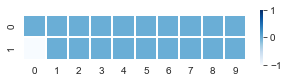

In [9]:
## HIDDEN
plt.subplots(figsize = (5,1))
sns.heatmap(crossings,linewidth = 1,cmap='Blues',vmin=-1,vmax=1,square=True);

Therefore, `locus 0` underwent a crossover on the second pair of chromatids. In this scenario, we will end up with $AABb$ and $aabB$ as shown below.

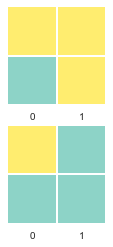

In [10]:
chromosomes(crossings,plot=True);

To count the percentage of recombinants, we can simply check how many chromatids are non-parental type over multiple rounds of meisosis. 

As an example, you can see in the case above that there are 2 recombinant chromatids $Ab$ and $aB$. Similarly, we can count the numbers after every simulated meiosis event.

### Multiple rounds of meiosis

In [11]:
mei = int(1e4) #number of rounds of meiosis
#as mei -> inf, the more accurate our esimate of rf

In [12]:
## HIDDEN
def test_cross(mei,N,p,alpha=[1,0]):
    recomb = np.zeros(mei)
    for i in range(mei):
        crossings = meiosis(N,p,alpha=alpha)
        X0,X1 = chromosomes(crossings)
        recomb[i] = np.sum(np.sum(X0,1)==1)+np.sum(np.sum(X1,1)==1)
    rf = np.sum(recomb)/(np.size(recomb)*4)
    return rf

In [13]:
rf = test_cross(mei,N,p); rf

0.44615

We can see that our model allows us to calculate the recombination frequency $(\theta)$ for a gap of $N$ loci between 2 genes on the same chromosome. 

### How does $\theta$ vary with $N$?

In [14]:
## HIDDEN
N_v = np.arange(1,80,1); p0 = 0.1; mei = 500
rf_v = np.zeros(np.shape(N_v))
for i,n in enumerate(N_v):
    p_i = p0*np.ones(n)
    rf_v[i] = test_cross(mei,n,p_i)

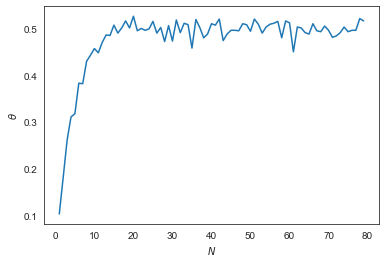

In [15]:
## HIDDEN
plt.plot(N_v,rf_v);
plt.xlabel("$N$"); plt.ylabel(r"$\theta$");

The fact that recombination frequency has a bound of $0.5$ bears out! This indicates that only within a certain linear range can we use the recombination frequency to estimate the distance between two genes on a chromosome.

### How does $\theta$ vary with the probability of crossing over $\rho$?

In [16]:
## HIDDEN
N0 = 10;  mei = 500; p0_v = np.arange(0.01,0.6,0.01)
rf_v = np.zeros(np.shape(p0_v))
for i,p0 in enumerate(p0_v):
    p_i = p0*np.ones(N0)
    rf_v[i] = test_cross(mei,N0,p_i)

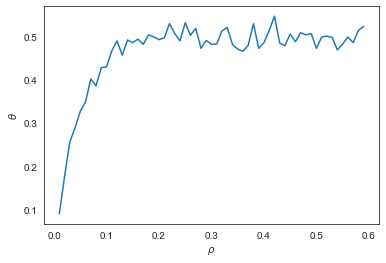

In [17]:
## HIDDEN
plt.plot(p0_v,rf_v)
plt.xlabel(r"$\rho$"); plt.ylabel(r"$\theta$");

As the probability $\rho$ of crossing over at any given locus increases, the recombination frequency also goes up. Again, we see that it has an upper bound of $0.5$.

### How does $ \theta $ vary over both $ \rho$ and $N$?

In [18]:
## HIDDEN
N_v = np.arange(1,40,3);
p0_v = np.arange(0.01,0.4,0.03); mei = 150; 
rf_v = np.zeros([np.size(N_v),np.size(p0_v)])
for i,n in enumerate(N_v):
    for j,p0 in enumerate(p0_v):
        p_i = p0*np.ones(n)
        rf_v[i,j] = test_cross(mei,n,p_i,alpha=[1,0])

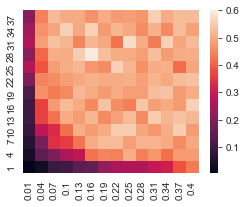

In [19]:
## HIDDEN
plt.figure(figsize= (4,3))
sns.heatmap(rf_v,square=True,yticklabels=N_v,xticklabels=np.round(p0_v,decimals=2));
plt.ylim(0,np.size(N_v));

You can see here that for low $\rho$ and $N$ values, $\theta$ goes up and then saturates around $0.5$.

## Does this fit the theory?

We expect the simulation to follow a Poisson model. This gives us a way to theoretically predict the relationship between $N\rho$ and $\theta$. The predicted relationship looks as follows:

$$\theta = \dfrac{1-e^{-2N\rho}}{2}$$

Does the simulation follow the expected relationship between $N\rho$ and $\theta$?

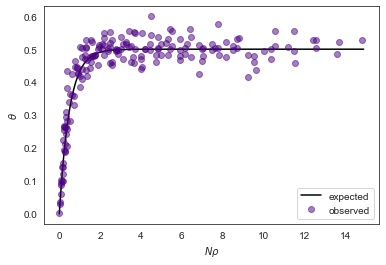

In [20]:
## HIDDEN
plt.figure()
x = np.arange(0,15,0.1)
y = (1 - np.exp(-2*x))/2
plt.plot(x,y,'k-')

for i,j in itertools.product(N_v,p0_v):
    x = i*j
    y = (rf_v[int(np.where(N_v==i)[0]),int(np.where(p0_v==j)[0])])
    plt.plot(x,y,'o',color='indigo',alpha=0.5)

plt.xlabel(r"$N\rho$")
plt.ylabel(r"$\theta$");
plt.legend(["expected","observed"],loc='lower right');

This is exactly what we expect. In fact, the quantity $N\rho$ in this Poisson process is the expected number of crossovers between the two genes $\text{A}$ and $\text{B}$ and by definition is equal to the genetic distance in $\text{Morgan}$ or $10^2\ \text{centiMorgan}$ or $10^2\ \text{map units}$.

## Crossing over events with both non-sister chromatids

Here, we introduce negative elements in the `crossings` array. What do these mean?  For `row 0`, `-1` at any one of these loci signifies a crossover with the outer non-sister chromatid whereas `+1` signifies a crossover with the inner non-sister chromatid. Similarly, for `row 1`, `+1` signifies a crossover with the outer non-sister chromatid and `-1` signifies a crossover with the inner non-sister chromatid (note the reversal in signs).

In [21]:
crossings = meiosis(N,p,state=0,sig=1,alpha=[0.5,0.5])

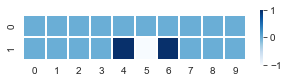

In [22]:
## HIDDEN
plt.subplots(figsize = (5,1))
sns.heatmap(crossings,linewidth = 1,cmap='Blues',vmin=-1,vmax=1,square=True);

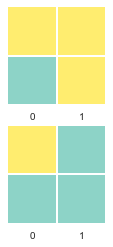

In [23]:
chromosomes(crossings,plot=True);

As in the above example you can visualize how a single chromatid crossing over with both non-sister chromatids in a meiotic event would end up.

### Is the upper bound on $\theta$ violated if a chromatid experiences crossover events with both non-sister chromatids?

We allow crossing over with both non-sister chromatids in the same meiotic event, but a crossover event at a locus is independent of crossover at every other locus. Let's define a vector $\alpha = [\alpha_1,\alpha_2]$ where 

$$\alpha_1 = P(\small\text{locus on outer chromatid forming chiasmata with outer non-sister chromatid})$$

$$\alpha_2 = P(\small\text{locus on inner chromatid forming chiasmata with outer non-sister chromatid})$$

If $\alpha = [1,0]$ or $[0,1]$, we reduce to the previous case of a single chromatid forming chiasmata with only one of the non-sisters.

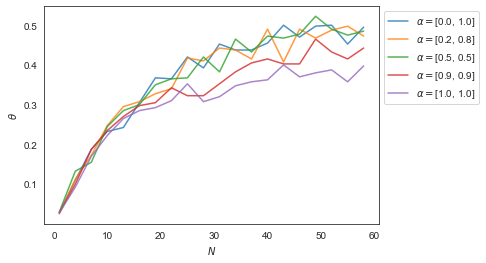

In [24]:
## HIDDEN
N_v = np.arange(1,60,3); p0 = 0.03; mei = 200
rf_v = np.zeros(np.shape(N_v))
leg = []
for alpha in np.array([[0,1],[0.2,0.8],[0.5,0.5],[0.9,0.9],[1,1]]):
    for i,n in enumerate(N_v):
        p_i = p0*np.ones(n)
        rf_v[i] = test_cross(mei,n,p_i,alpha=alpha)
    leg.append(r"$\alpha = $"+str(list(np.round(alpha,decimals=2))))
    plt.plot(N_v,rf_v,alpha=0.8)
plt.legend(leg,bbox_to_anchor=(1, 1))
plt.xlabel("$N$"); plt.ylabel(r"$\theta$");

As long as crossover events at a locus remain independent of crossover events at other loci, the $0.5$ upper bound on recombination frequency holds up. If there is a bias towards forming chiasmata with a single non-sister chromatid, then the $\theta$-$N$ curve shifts downward.

## Introducing Recombination Hotspots

Let's introduce a single recombination hotspot between the genes.

In [25]:
N = 10
p = 0.1*np.ones(N); p[int(N/2)] = 0.7
mei = int(1e4)

In [26]:
rf = test_cross(mei,N,p); rf

0.52255

Notice how $\theta>0.5$ for $10^4$ rounds of meiosis.

### How does $\theta$ vary with $N$ in the presence of a hotspot?

In [27]:
## HIDDEN
N_v = np.arange(1,80,1); p0 = 0.1; mei = 500
rf_v = np.zeros(np.shape(N_v))
for i,n in enumerate(N_v):
    p_i = p0*np.ones(n); p_i[int(n/2)] = 0.7
    rf_v[i] = test_cross(mei,n,p_i,alpha=[0.5,0.5])

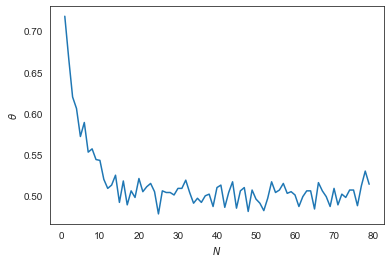

In [28]:
## HIDDEN
plt.plot(N_v,rf_v);
plt.xlabel("$N$"); plt.ylabel(r"$\theta$");

For a single recombination hotspot between 2 genes, $\theta$ lies close to the probability of crossover at the recombination hotspot for low values of $N$ and tends to $0.5$ for high values of $N$. Therefore, if the probability of crossover is greater than $0.5$ at the recombination hotspot, we can get $\theta > 0.5$ in experimental crosses but only if the genes are located close to the recombination hotspot.

### How does $\theta$ vary with the number of recombination hotspots $(\eta)$?

We need to choose a value of $N$ for which the effect of a recombination hotspot would be visible, say $N = 10$ based on the previous plot.

In [29]:
## HIDDEN
M = 10 #number of simulations to cancel out the noise
rf_v = np.zeros([N0,M])
N0 = 10; p0 = 0.1; mei = 1000
eta = np.arange(0,N0,1)
for j in range(M):
    p_i = p0*np.ones(N0)
    for i,et in enumerate(eta):
        number = np.random.randint(N0,size=et)
        p_i[number] = 0.7
        rf_v[i,j] = test_cross(mei,N0,p_i,alpha=[0.5,0.5])
rf_v = np.ravel(rf_v,order='F')
eta = np.array(list(eta)*M)

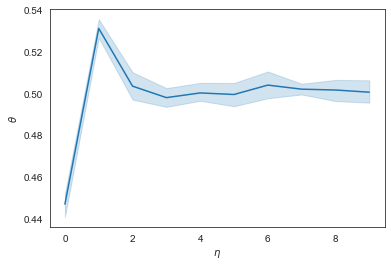

In [30]:
## HIDDEN
sns.lineplot(eta,rf_v)
plt.xlabel("$\eta$"); plt.ylabel(r"$\theta$");

For $\eta > 1$, $\theta$ drops back to $0.5$.